# Reanalysis of Sigaki et al.'s paintings analysis using ComplexityMeasures.jl

In [1]:
using Pkg;
Pkg.activate("./")

  Activating project at `~/Code/Repos/sigaki_paintings_reproduction`


## Painting metadata

We've pre-downloaded the metadata for all artists in the Wikiart database (per July 6th 2023) using 
the python package at [https://github.com/lucasdavid/wikiart](https://github.com/lucasdavid/wikiart). There's 5511 artists in total, each with one or more paintings (may change if you re-download the metadata).

In [2]:
artist_files = readdir("./data/meta")
length(artist_files)

5511

Let's see what type of categories of paintings we have.

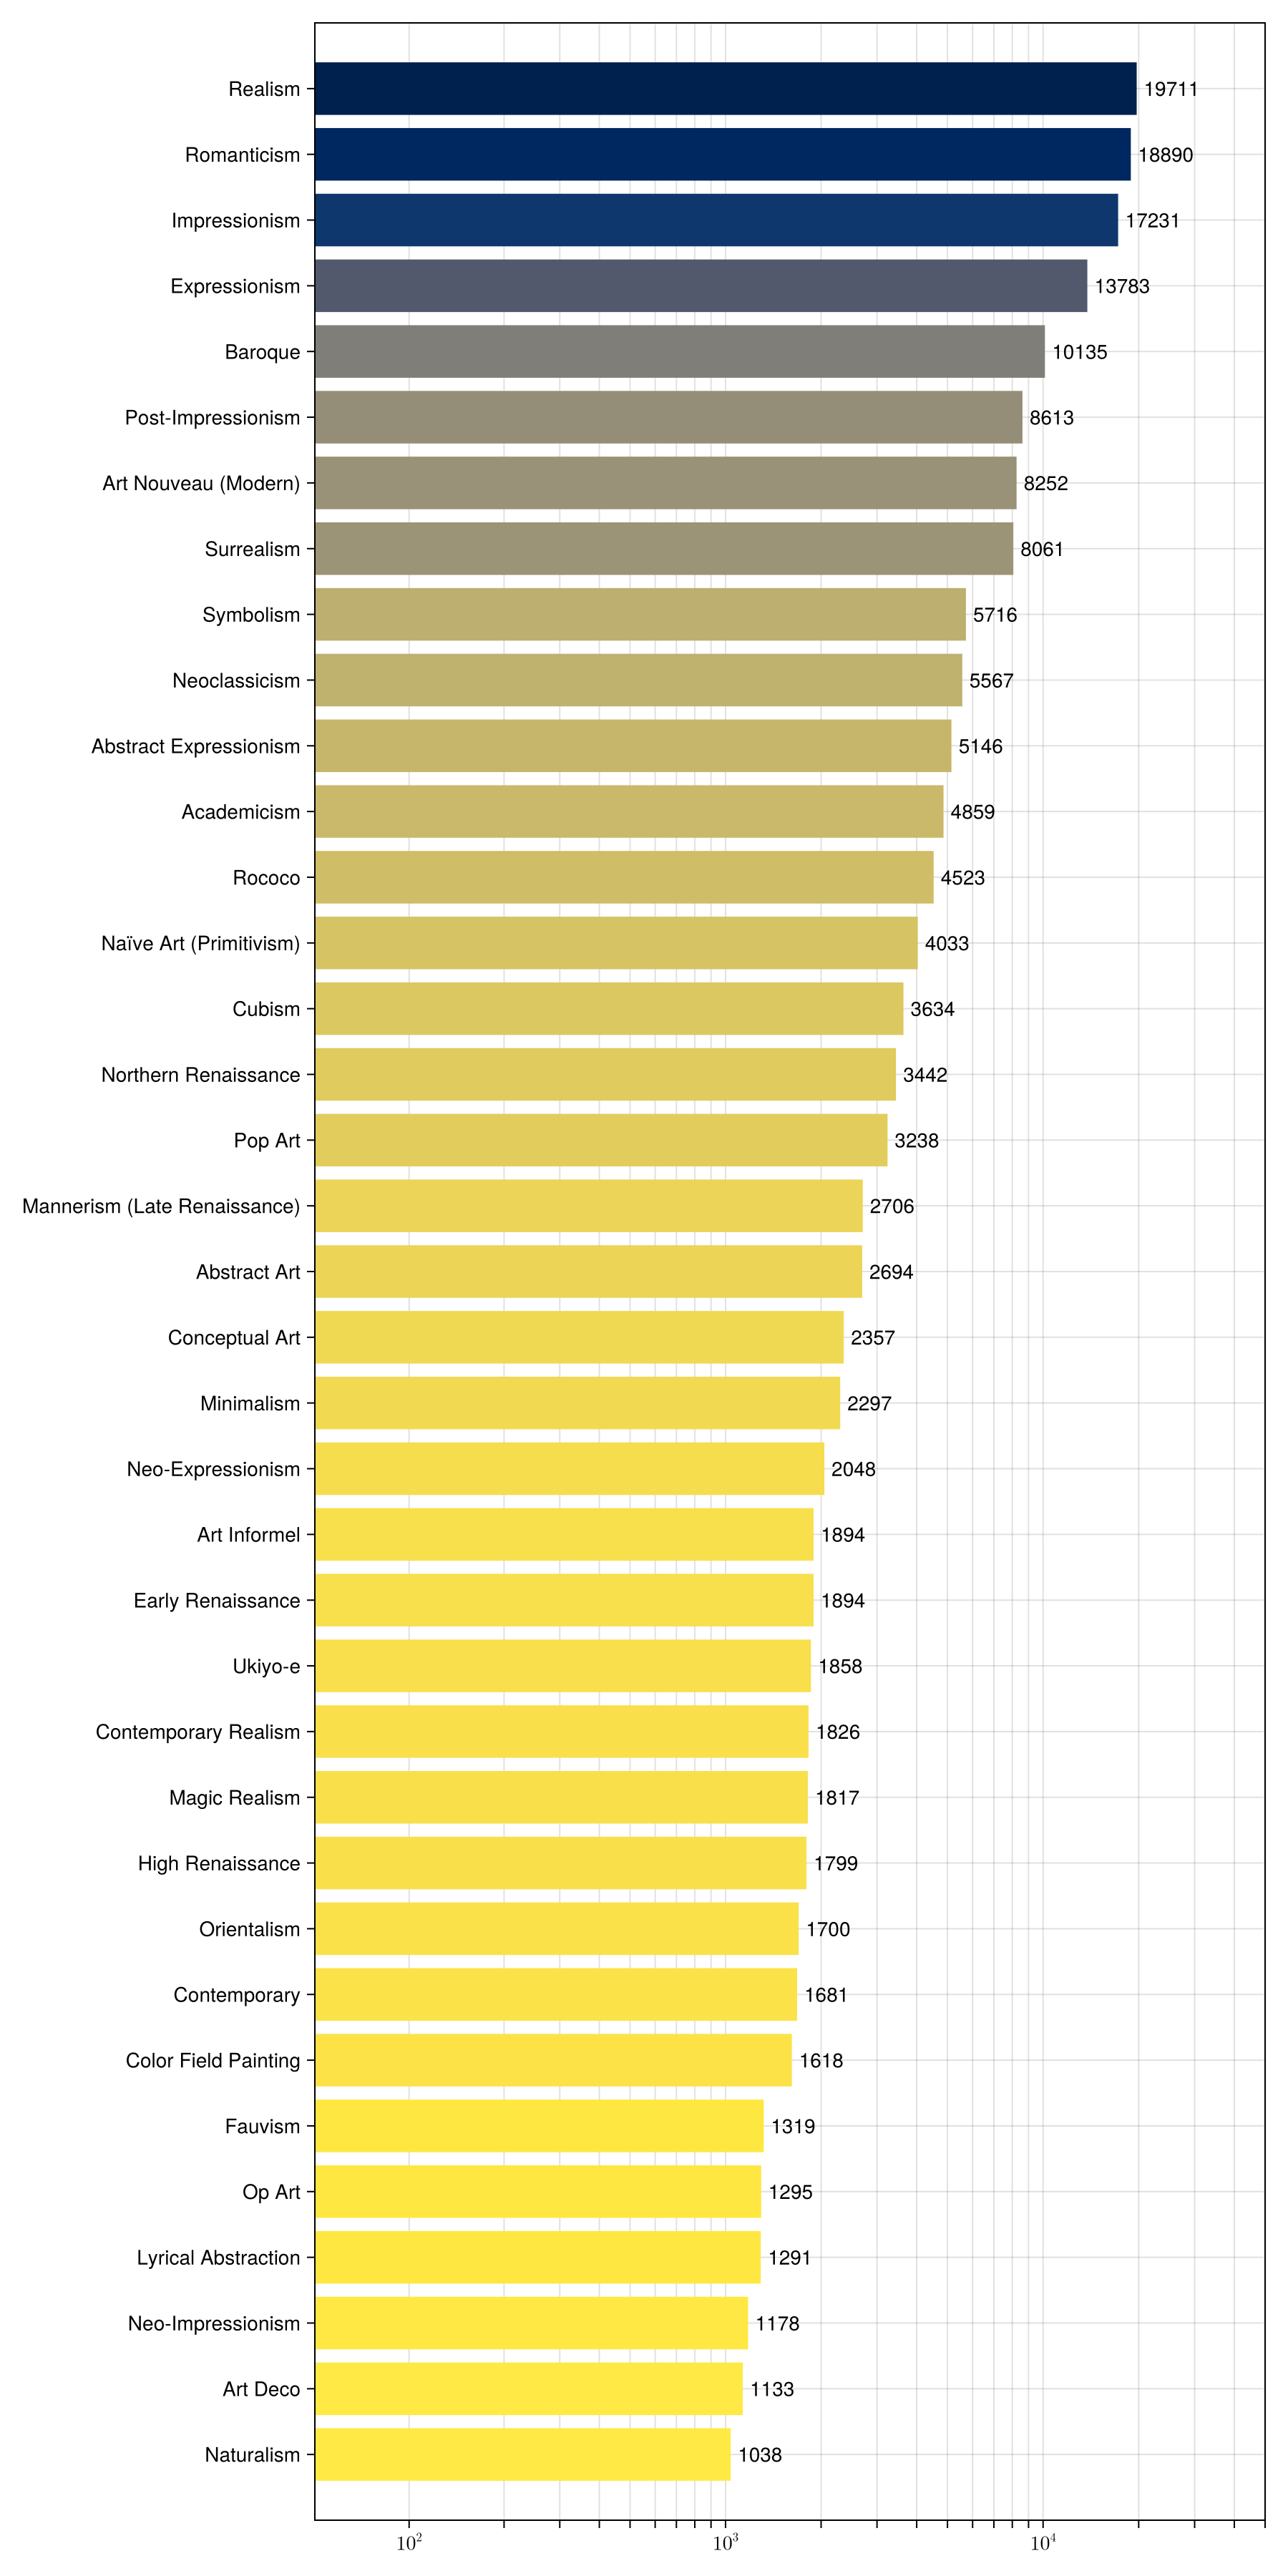

CairoMakie.Screen{IMAGE}


In [4]:
include("./scripts/plotting/style_histogram.jl")
# Include styles with 1000 paintings or more
f = fig_histogram(; threshold = 1000, rev = false, colorscale = :cividis); 
save("fig_frequency_hist.pdf", f)
display(f)


## Download data

The `scripts/download_paintings.jl` file processes the metadata and downloads the paintings for each artist. Note: for many artists, there is a mismatch between the number of paintings listed in the metadata and the number of paintings downloaded. This is is due to the fact that some paintings point to invalid download URLs. If you downloaded the metadata more recently, this might have improved.

Note: downloading the paintings takes a *long* time to run. There is roughly 28,5 GB of data to be downloaded.

In [93]:
include("scripts/download_paintings.jl")

download_artists (generic function with 1 method)

To download the paintings as local files, please uncomment the following code block.
For convenience, we've grouped the paintings into batches. Paintings that have already been 
downloaded will not be downloaded again.

In [5]:
# Downloads and processes all paintings, converts them to Float32 arrays, and
# stores them as png files. 
#download_artists(1:500)
#download_artists(501:1000)
#download_artists(1001:1500)
#download_artists(1501:2000)
#download_artists(2001:2500)
#download_artists(2501:3000)
#download_artists(3001:3500)
#download_artists(3501:4000)
#download_artists(4001:4500)
#download_artists(4501:5000)
#download_artists(5001:5500)
#download_artists(5501:5511)

## Reproduce analysis

Computing the `StatisticalComplexity` measure is amazingly simple. Here's an example.

In [7]:
using ComplexityMeasures, Distances

# Example image of 50x50 pixels
x = rand(50, 50)

# Discretize the image data using the `SpatialOrdinalPatterns` outcome space.
stencil = [1 1; 1 1] # square 2x2 stencil
outcome_space = SpatialOrdinalPatterns(stencil, x)

# What type of information measure estimator do we want to use? We'll pick Tsallis entropy,
# estimated using using the naive `PlugIn` estimator.
infodef = PlugIn(Tsallis())

# Define the statistical complexity estimator.
s = StatisticalComplexity(o = outcome_space, hest = infodef, pest = BayesianRegularization(),
    dist = JSDivergence())

# The values of H "the entropy" and C "the complexity"
ex_h, ex_c = entropy_complexity(s, x) 

(0.9984178715816051, 0.0020661209823137463)

Now, we'll do the same for all paintings in the dataset, using two different estimators
based on the `SpatialOrdinalPatterns` and the `SpatialDispersion` outcome spaces. We'll
use `Shannon` entropy estimated using the naive `PlugIn` estimator for both cases.

In [59]:
include("scripts/process_and_analyze.jl")

run_analysis (generic function with 1 method)

Running each of the analyses takes a long time (roughly a day on a 2020 Macbook Air M1 using all eight cores). This hasn't been optimized for speed in any way, so could probably be sped up. 

In [8]:
#spatial_analysis([1 1; 1 1], "square2x2_permutation"; est_type = :permutation)
#spatial_analysis([1 1; 1 1], "square3x3_corners_dispersion"; est_type = :dispersion, c = 3)

Plotting the results is just a matter of referencing the files containing the results,
which are in the `output` folder. Output file names contain the time at which the analysis 
was run, so we'll just write them out manually (change these file names
if you re-run the analysis).

In [14]:
include("./scripts/plotting/entropy_complexity_plots.jl")

final_fig (generic function with 1 method)

Now plot the results. We'll skip adding a legend, because it is not relevant for our 
paper. There's code in the `scripts/plotting/entropy_complexity_plots.jl` file to add 
a legend, which you can play around with.

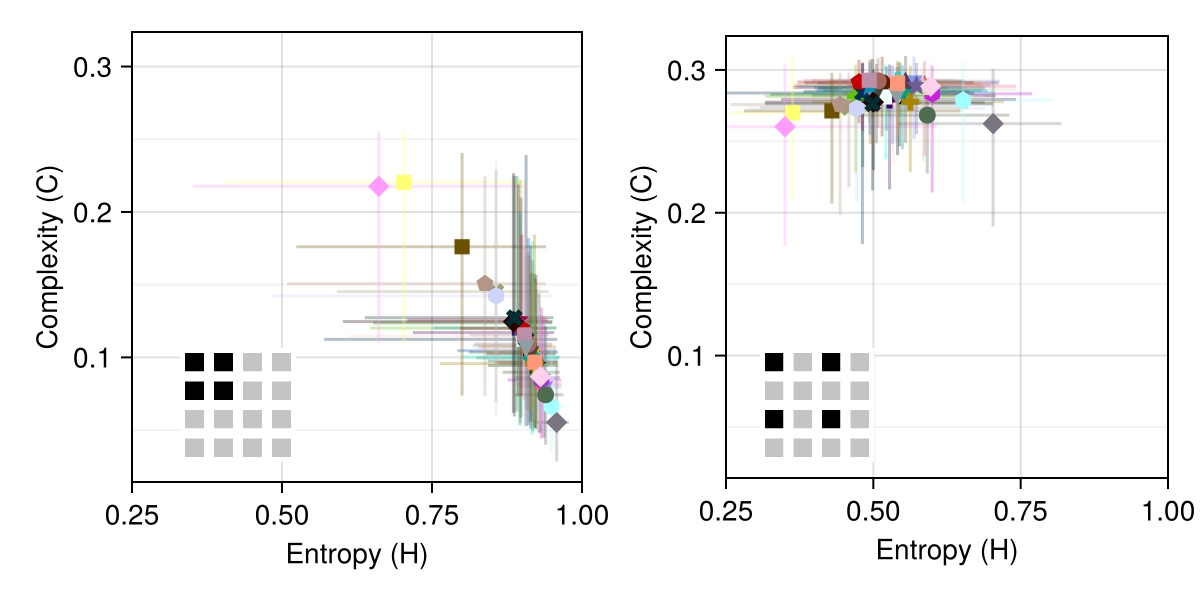

In [27]:
filenames = [
    "reproduction_square2x2_permutation_2024_44_23_15:44.jld2", 
    "reproduction_square3x3_corners_dispersion_2024_38_23_22:38.jld2",
    ]

# Only plot results for styles that have more than 1000 paintings.
# Bars on scatter points display the 10th to 90th percentile ranges.
fig = final_fig(filenames...; threshold = 500, lq = 0.1, uq = 0.9)

In [28]:
CairoMakie.save("fig_entropy_complexity_sigaki_reproduction.pdf", fig)

CairoMakie.Screen{PDF}
